<a href="https://colab.research.google.com/github/phuongnt3391/Timeseries/blob/main/AutoRegressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --upgrade statsmodels

     |████████████████████████████████| 9.5 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import statsmodels

In [3]:
statsmodels.__version__

'0.12.2'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('us_airline_carrier_passenger.csv')

In [12]:
df.tail()

,month,passengers
235,2019-08-01,83784
236,2019-09-01,72590
237,2019-10-01,78617
238,2019-11-01,73074
239,2019-12-01,79302


In [7]:
df.dtypes

month         object
passengers     int64
dtype: object

In [8]:
df['month'] = pd.to_datetime(df['month'])

In [9]:
df.dtypes

month         datetime64[ns]
passengers             int64
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       240 non-null    datetime64[ns]
 1   passengers  240 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


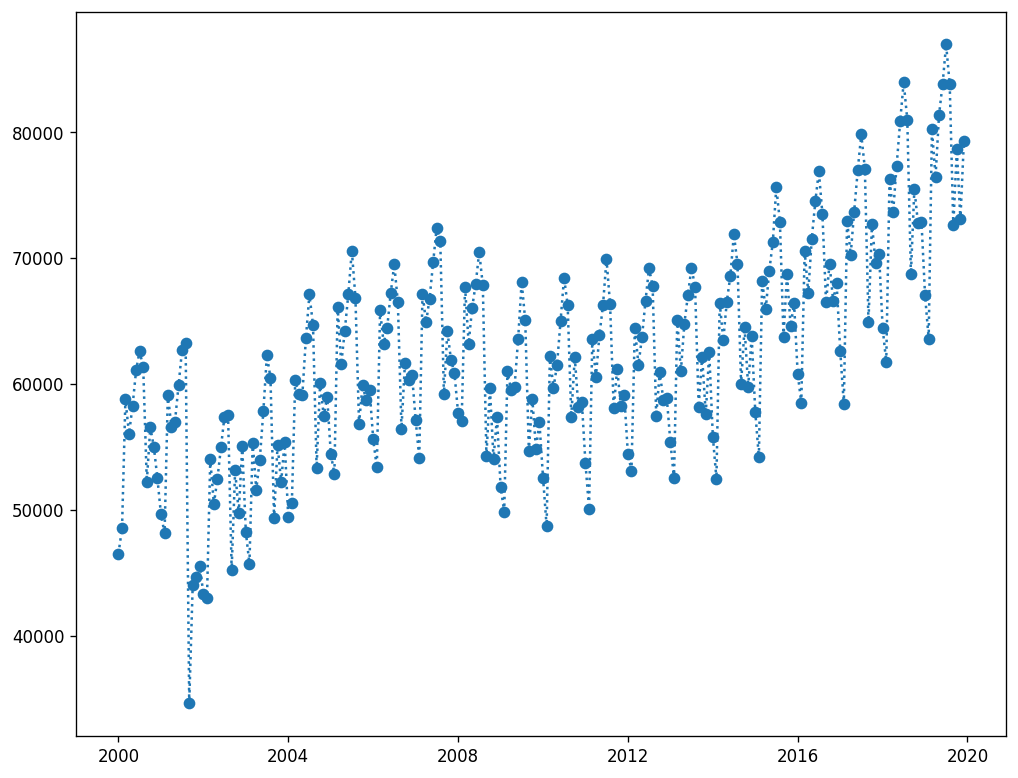

In [11]:
plt.figure(figsize=(10,8),dpi=120)
plt.plot(df['month'],df['passengers'],'o:')

Split data into training and test set
* Training: up until 2016-12-01
* Test: from 2017-01-01 until 2019-12-01


In [17]:
import datetime
df_train = df[df['month'] <= datetime.datetime.strptime('2016-12-01','%Y-%m-%d')] 

In [18]:
df_train.tail()

,month,passengers
199,2016-08-01,73450
200,2016-09-01,66477
201,2016-10-01,69539
202,2016-11-01,66591
203,2016-12-01,67983


In [19]:
df_train.shape

(204, 2)

In [20]:
df_test = df[df['month'] > datetime.datetime.strptime('2016-12-01','%Y-%m-%d')] 

In [22]:
df_test.head()

,month,passengers
235,2019-08-01,83784
236,2019-09-01,72590
237,2019-10-01,78617
238,2019-11-01,73074
239,2019-12-01,79302


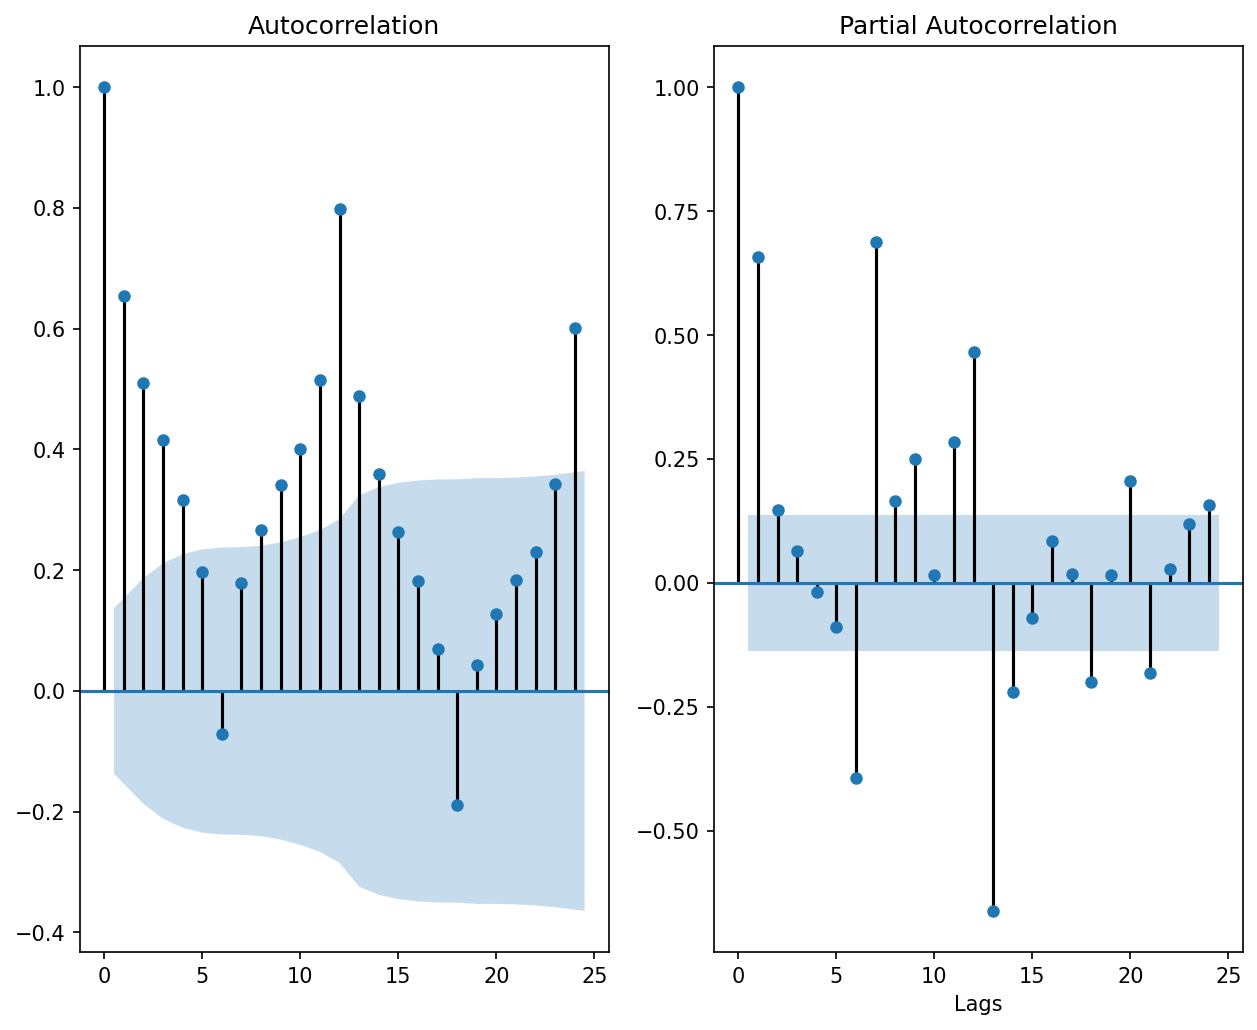

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(nrows =1, ncols = 2, figsize=(10,8), dpi = 150)
res1 = plot_acf(df_train['passengers'], ax = ax[0])
res2 = plot_pacf(df_train['passengers'], ax = ax[1])
plt.xlabel('Lags')
plt.show()

As from the above plot, every 12 months, the trend seems to repeat; so choose lags = 12 

Make the data stationary by clearing seasonality at 12 periods

Auto Regressive Model
p: number of lags
find p using the PACF plot 
12 lags

In [29]:
X_train = df_train.set_index('month')

In [30]:
X_test = df_test.set_index('month')

In [31]:
from statsmodels.tsa.ar_model import AutoReg

In [32]:
model_ar = AutoReg(X_train, lags=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [35]:
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:             passengers   No. Observations:                  204
Model:                    AutoReg(12)   Log Likelihood               -1791.208
Method:               Conditional MLE   S.D. of innovations           2725.128
Date:                Mon, 27 Sep 2021   AIC                             15.966
Time:                        09:23:42   BIC                             16.204
Sample:                    01-01-2001   HQIC                            16.063
                         - 12-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1101.8877   2670.461     -0.413      0.680   -6335.894    4132.119
passengers.L1      0.4234      0.062      6.848      0.000       0.302       0.545
passengers.L2      0.0487      0.069

In [36]:
#Fitted values
fitted_values = model_ar.fittedvalues

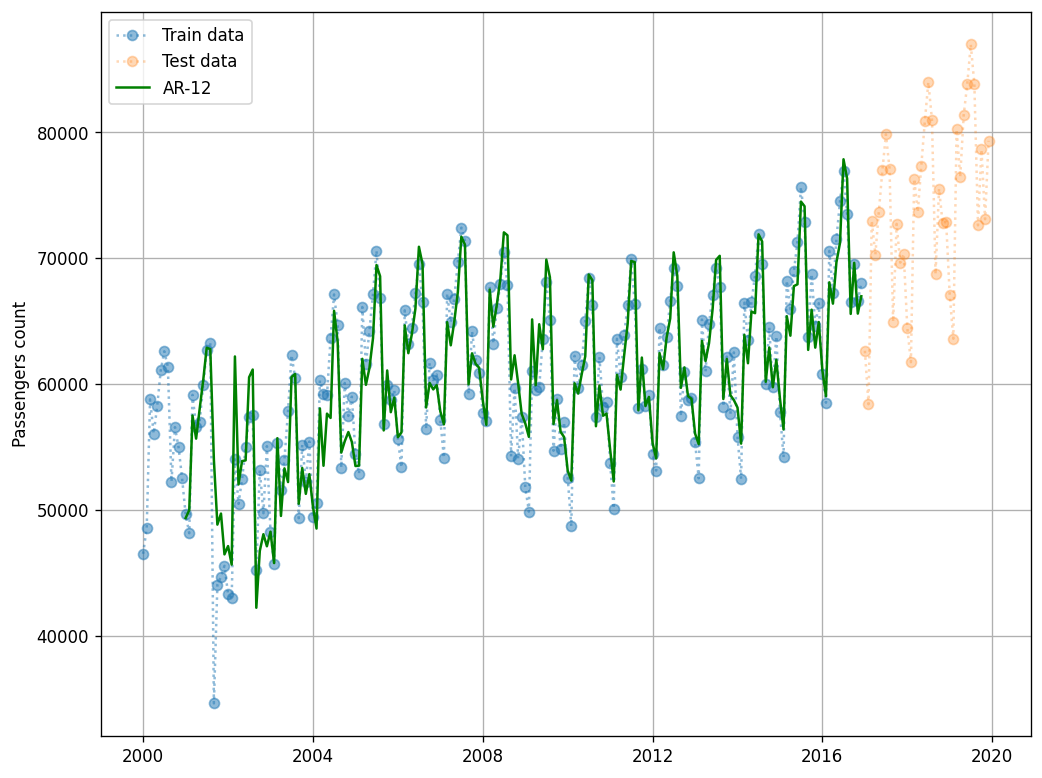

In [44]:


# Visualize the data
plt.figure(figsize =(10,8),dpi=120)
plt.plot(df_train['month'],df_train['passengers'],'o:',alpha = 0.5)
plt.plot(df_test['month'],df_test['passengers'],'o:',alpha = 0.3)
plt.plot(fitted_values,'g')

plt.legend(['Train data','Test data','AR-12'])
plt.grid()

plt.ylabel('Passengers count')
plt.show()



Try to predict data

In [45]:
start = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
end = datetime.datetime.strptime('2019-12-01','%Y-%m-%d')
forecasted_values = model_ar.predict(start=start,end=end)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [46]:
forecasted_values.head()

2017-01-01    63865.557371
2017-02-01    63222.994100
2017-03-01    70781.913370
2017-04-01    68039.617829
2017-05-01    71141.883579
Freq: MS, dtype: float64

In [52]:
error = model_ar.resid.std()
ME = 1.96*error #(95% Confidence Interval)


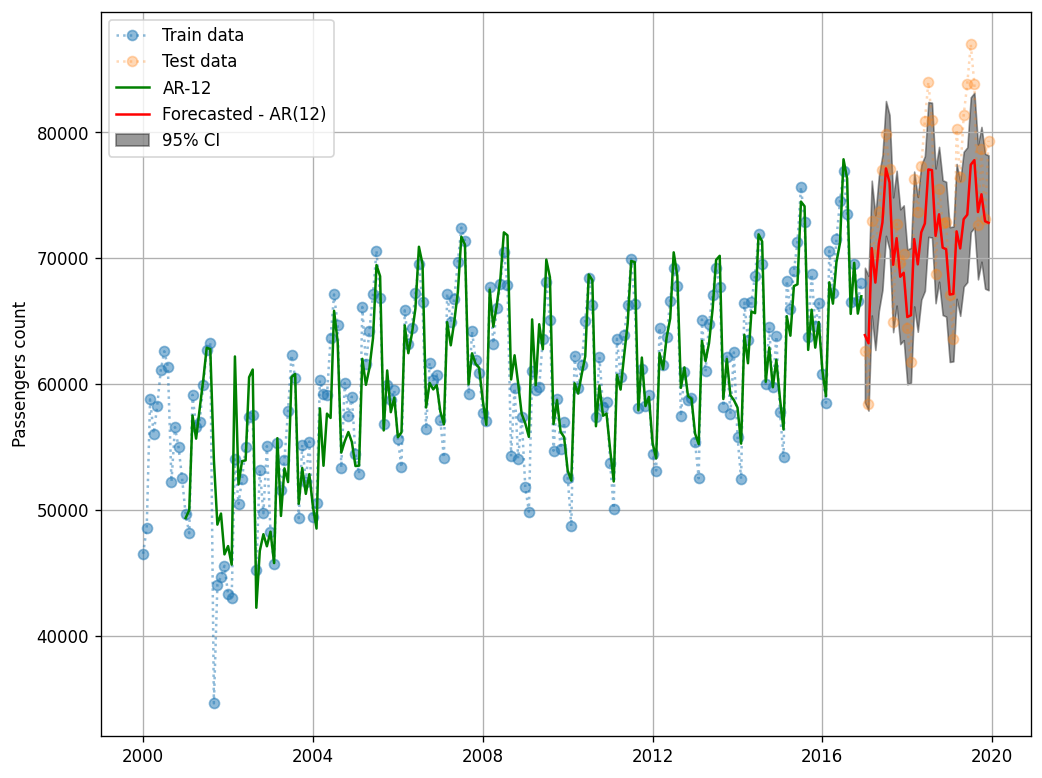

In [54]:
# Visualize the data
plt.figure(figsize =(10,8),dpi=120)
plt.plot(df_train['month'],df_train['passengers'],'o:',alpha = 0.5)
plt.plot(df_test['month'],df_test['passengers'],'o:',alpha = 0.3)
# Fitted values
plt.plot(fitted_values,'g')
# Forecasted values
plt.plot(forecasted_values, 'r')
# Margin of error
ci_plus = forecasted_values + ME
ci_minus = forecasted_values - ME
plt.fill_between(df_test['month'],ci_plus,ci_minus,alpha=0.4, color='black' )
plt.legend(['Train data','Test data','AR-12','Forecasted - AR(12)','95% CI'])
plt.grid()

plt.ylabel('Passengers count')
plt.show()

Evaluation

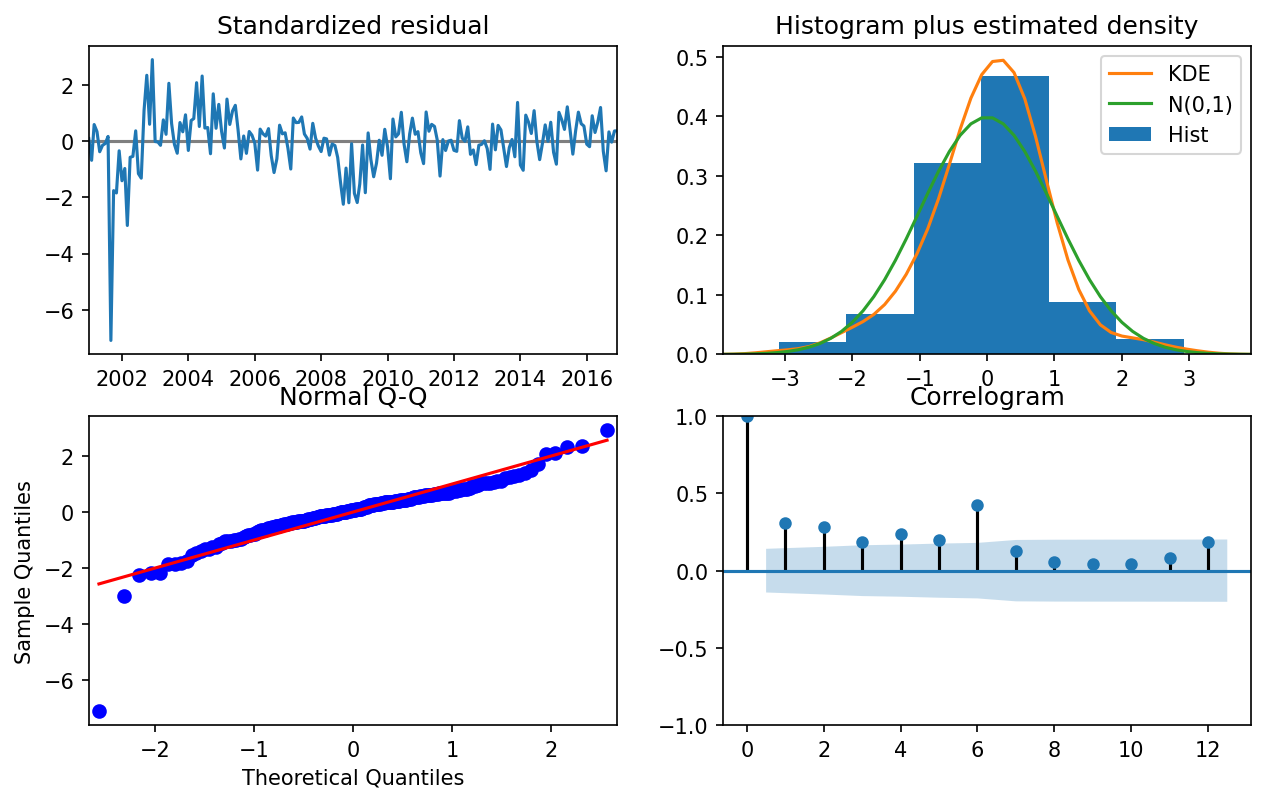

In [60]:
fig = plt.figure(figsize=(10,6), dpi=150)
fig = model_ar.plot_diagnostics(lags=12, fig=fig)

* From the Histogram, the orange line is what the model predicts, the green line is the actual true values.
* From the Standardized residual, it seems that it's purely noise level
* From the Correlation plot, only the 1st value has correlation is 1, others have values almost 0; so we can regard them as random.
* I can say that no pattern left out here; the model is pretty good.
